# Example: Payoff and Profit of Composite Contracts at Expiration
In this example, we will analyze the payoff and profit of composite contracts consisting of long (short) call (put) options contracts written on the same underlying asset with the same expiration date.

> __Learning Objective:__ 
> 
> By the end of this example, you will be able to:
> 
> Three learning objectives go here.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
To start, load the options data using using the `MyOptionsChainDataSet(...)` function and store the data in the `options_dataset` variable:

In [2]:
options_dataset = MyOptionsChainDataSet()

(metadata = Dict{String, Any}("DTE" => "58", "purchase_date" => "2025-10-22", "historical_volatility" => "0.7971", "underlying_share_price_ask" => "225.91", "source" => "barchart.com", "underlying_share_price_bid" => "225.74", "is_weekly" => false, "atm_IV" => "0.5903", "expiration_date" => "2025-12-19", "underlying_share_price_mid" => "225.78"…), data = 129×11 DataFrame
 Row │ Strike                             Moneyness     Bid         Mid        ⋯
     │ String                             Float64?      Float64?    Float64?   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 25.00                                    0.8907      203.1       204.0  ⋯
   2 │ 30.00                                    0.8688      198.2       199.05
   3 │ 35.00                                    0.847       193.2       193.98
   4 │ 40.00                                    0.8251      188.3       189.1
   5 │ 45.00                                    0.8033      183.25

Next, we set some constants that are used below:

In [3]:
Sₒ = 117.50; # set the initial share price (this has no importance now because we have the options chain data)

## Directional: Credit and Debt Vertical Spreads
[Vertical spreads](https://www.fidelity.com/bin-public/060_www_fidelity_com/documents/learning-center/Deck_Vertical-spreads.pdf), a defined risk directional strategy, involve buying and selling the same type of option with different strike prices and the same expiration date. Vertical spreads can be open for a credit or debit and have defined risk.
* This type of trade has two legs a long leg (the option purchased by the investor) and a short leg (the option sold by the investor).
* The investor can use the strategy to take a position on whether the share price of the underlying stock, such as `XYZ,` will increase or decrease. Thus, it is a directional strategy.

### Bullish `put` credit spread
A `put` vertical spread is constructed by combining `2` $\times$ `put` contracts, a short `put` contract generates income while the `long` put contract controls downside risk.  Let contract $j$ have a strike price of $K_{j}$ and premium $\mathcal{P}_{j}$. The share price at expiration is given by $S(T)$. Finally, let contract 1 be the short leg $\theta_{1} = -1$ and contract 2 be the long leg $\theta_{2} = 1$. Then, the profit for a single `put` vertical spread at expiration is given by:

$$\hat{P} = -P_{1}+P_{2}$$

which, after substitution of the profit functions for a put contract, gives:

$$
\hat{P} = \left(K_{2} - S\right)^{+} - \left(K_{1} - S\right)^{+} + \left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$$

where $V_{p} = (K-S)^{+}=\max(K-S,0)$ is the payoff function for a `put` contract. The first term is the net payout of the two legs of the spread, while the second term is the net cost of the two contracts. The maximum possible profit, loss, and breakeven conditions are given by:

* The maximum possible profit of $\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S\geq{K_{1}}$.
* The maximum possible loss of $K_{2} - K_{1} + \left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S\leq{K_{2}}$.
* The vertical put spread will breakeven when $S =  K_{1}+\left(\mathcal{P}_{2} - \mathcal{P}_{1}\right)$.

Let's build a bullish put credit spread for `AMD` whose current share price is `S(0) = 117.50 USD/share`. This trade structure is constructed by selling (short) a `put` with strike $K_{1}$ and buying (long) a `put` with strike $K_{2}$. 

* Leg 1: The strike price for the `short put` leg is given by $K_{1}$ = 130 USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `long put` leg is given by $K_{2}$ = 110 USD/share with `DTE = 31 days`

#### Implementation
To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables). We then utilize `build(...)` methods to construct option contract models. Next, we generate an array of share prices at expiration and store them in the `S` array. Using the `profit(...)` function, we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help of `plot(...)` functions from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

In [4]:
let

    K₁ = 130.0
    K₂ = 110.0
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K₁ && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K₂ && y == "Put"), options_dataset)[1,:Midpoint];
     
    max_loss = K₂ - K₁ + (premium_1 - premium_2);
    max_profit = (premium_1 - premium_2);
    
    put_contract_model_short = build(MyAmericanPutContractModel, (
            K = K₁, premium = premium_1, sense = -1, copy = 1
    ));

    put_contract_model_long = build(MyAmericanPutContractModel, (
            K = K₂, premium = premium_2, sense = 1, copy = 1
    ));
    
    S = range(0.9*K₂,stop = 1.1*K₁, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model_short, put_contract_model_long], S);
    breakeven = K₁ + (premium_2 - premium_1)
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (short)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Put (long)", ls=:dash, c=:navyblue)
    
    plot!(S,BEL,lw=2, c=:green, label="")
    scatter!([breakeven], [0], c=:black, label="breakeven = $(breakeven) USD/share", ms=5)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short)", msc=:black, mc=:white)
    scatter!([K₂],[max_loss], ms=5, label = "K₂ = $(K₂) (long)", msc=:black, mc=:white)

    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

MethodError: MethodError: objects of type Pair{Vector{Symbol}, var"#18#19"{Float64}} are not callable
The object of type `Pair{Vector{Symbol}, var"#18#19"{Float64}}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

### Bearish `call` credit spread
A bear `call` credit spread, is an options strategy used when a trader expects a __decline__ in the price of the underlying asset. For this trade, assume the initial share price of the underlying asset is $S_{o}$. We __sell__ a `call` contract at $K_{1}<S_{o}$ for $\mathcal{P}_{1}$, and __buy__ a `call` contract at $K_{2}>S_{o}$ for $\mathcal{P}_{2}$. Let's consider a trade on `MU` with the following parameters:

* The initial share price of `MU` is $S_{o}$ = 65.60 USD/share.
* The premium for the `short call` leg with strike $K_{1}=$ 63 is $\mathcal{P}_{1}$ = 4.35 USD/share.
* The premium for the `long call` leg with strike $K_{2}=$ 70 is $\mathcal{P}_{2}$ = 1.10 USD/share.

#### Profit and Breakeven Analysis
The profit function for the bear `call` credit spread is given by:

$$
\hat{P} = (S-K_{2})^{+} - (S-K_{1})^{+} + (\mathcal{P}_{1}-\mathcal{P}_{2})
$$

where $V_{c} = (S-K)^{+}=\max(S-K,0)$ is the payoff function for a `call` contract. The first two terms are the net payout of the two legs of the spread, while the last term is the net cost of the two contracts. The maximum possible profit, loss, and breakeven conditions are given by:

* The maximum possible profit of $\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S\leq{K_{1}}$.
* The maximum possible loss of $\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right) -(K_{2} - K_{1})$ will occur when $S\geq{K_{2}}$.
* The bear `call` spread will breakeven when $S =  K_{1}+\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$.

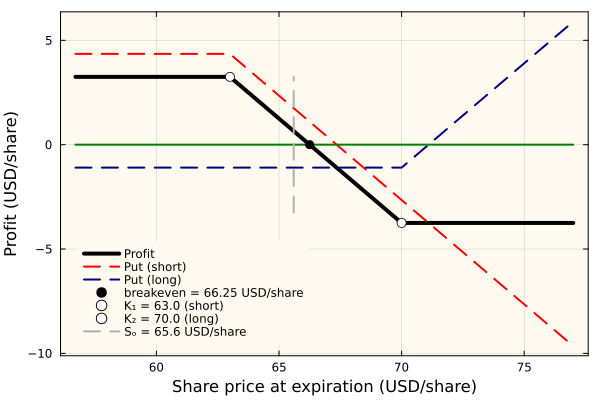

In [5]:
let

    K₁ = 63.0
    K₂ = 70.0
    premium_1 = 4.35
    premium_2 = 1.10
    Sₒ = 65.60
     
    max_loss = (premium_1 - premium_2) - (K₂ - K₁)
    max_profit = (premium_1 - premium_2);
    
    call_contract_model_short = build(MyAmericanCallContractModel, (
            K = K₁, premium = premium_1, sense = -1, copy = 1
    ));

    call_contract_model_long = build(MyAmericanCallContractModel, (
            K = K₂, premium = premium_2, sense = 1, copy = 1
    ));
    
    S = range(0.9*K₁,stop = 1.1*K₂, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([call_contract_model_short, call_contract_model_long], S);
    breakeven = K₁ + (premium_1 - premium_2)
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (short)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Put (long)", ls=:dash, c=:navyblue)
    
    plot!(S,BEL,lw=2, c=:green, label="")
    scatter!([breakeven], [0], c=:black, label="breakeven = $(breakeven) USD/share", ms=5)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short)", msc=:black, mc=:white)
    scatter!([K₂],[max_loss], ms=5, label = "K₂ = $(K₂) (long)", msc=:black, mc=:white)

    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

In [6]:
let
    K₁ = 63.0
    K₂ = 70.0
    premium_1 = 4.35
    premium_2 = 1.10
    Sₒ = 65.60

    max_loss = (premium_1 - premium_2) - (K₂ - K₁)
    max_profit = (premium_1 - premium_2);
    breakeven = K₁ + (premium_1 - premium_2)

    println("Call credit spred: Max loss: $(max_loss), Max profit: $(max_profit) and breakeven $(breakeven)")
end

Call credit spred: Max loss: -3.7500000000000004, Max profit: 3.2499999999999996 and breakeven 66.25


## Neutral: Straddles and Strangles

### Straddles
A [straddle](https://www.investopedia.com/terms/s/straddle.asp) is a _neutral strategy_ constructed by simultaneously buying (or selling) a put and a call option on the same underlying asset `XYZ`, with the _same expiration_, and the _same strike price_. Depending upon the choice of the strike prices and whether an investor buys or sells both legs, a [straddle](https://www.investopedia.com/terms/s/straddle.asp) can be initiated as a credit or debit and can potentially have undefined profit or loss.

Let $K_{j}$ denote the strike price of contract $j$ (USD/share), where the price of contract $j$ is $\mathcal{P}_{j}$ (USD/share). Finally, let index $j=1$ denote the `put` contract, $j=2$ denote the `call` contract; for a straddle $K_{1}= K_{2}\equiv{K}$ (both legs have the same strike). The profit for a single straddle contract $\hat{P}$ at expiration is given by:

$$\hat{P} = \theta\cdot\left(P_{1}+P_{2}\right)$$

where $\theta_{1}=\theta_{2}\equiv\theta$ denotes a direction parameter: $\theta=-1$ if each leg is sold (short), $\theta=1$ otherwise. After substitution of the profit functions for a `put` and a `call` contract, the overall profit $\hat{P}$ is given by:

$$\hat{P} = \theta\cdot\Bigl[(K-S)^{+}+(S-K)^{+}-(\mathcal{P}_{1}+\mathcal{P}_{2})\Bigr]$$

where $V_{p} = (K-S)^{+}=\max(K-S,0)$ is the payoff function for the `put` contract, and $V_{c} = (S-K)^{+} = \max(S-K,0)$ is the payoff function for the `call` contract. The profit (or loss) of a straddle has three regimes given by:

$$
\hat{P} = \begin{cases}
  \theta\cdot\Bigl[(S-K)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr]  & S>K \\
  -\theta\cdot\Bigl[\mathcal{P}_{1}+\mathcal{P}_{2}\Bigr] & S=K \\
    \theta\cdot\Bigl[(K-S)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr] & S<K
\end{cases}
$$

Finally, a straddle has _two_ possible breakeven points denoted as $S^{+}$ and $S^{-}$:
* If $S>K$: a straddle will breakeven at $S^{+} = K + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$
* If $S<K$: a straddle will breakeven at $S^{-} = K - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$.

#### Long straddle
For a long straddle, we purchase (are long) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Let's contruct the profit diagram for a long straddle with the parameters:

* Leg 1: The strike price for the `long put` leg is given by $K_{1}$ = 120 USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `long call` leg is given by $K_{2}$ = 120 USD/share with `DTE = 31 days`

##### Implementation
To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables). We then utilize `build(...)` methods to construct option contract models. Next, we generate an array of share prices at expiration and store them in the `S` array. Using the `profit(...)` function, we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help of `plot(...)` functions from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

In [7]:
let
    
    K = 120.0
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Midpoint];

    max_loss = -1*(premium_1 + premium_2);
    
    put_contract_model = build(MyAmericanPutContractModel, (
            K = K, premium = premium_1, sense = 1, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K, premium = premium_2, sense = 1, copy = 1
    ));
    
    S = range(90,stop = 150, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K + (premium_1 + premium_2);
    breakeven_array[2,1] = K - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        legend=:top)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (long)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call (long)", ls=:dash, c=:navyblue)
    plot!(S,BEL,lw=3, c=:green, label="")
    
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="Breakeven", ms=5)
    scatter!([K],[max_loss], ms=5, label = "K = $(K)", msc=:black, mc=:white)
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

MethodError: MethodError: objects of type Pair{Vector{Symbol}, var"#24#25"{Float64}} are not callable
The object of type `Pair{Vector{Symbol}, var"#24#25"{Float64}}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

#### Short straddle
For a short straddle, we sell (are short) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Let's contruct the profit diagram for a _short straddle_ with the parameters:

* Leg 1: The strike price for the `short put` leg is given by $K_{1}$ = `120` USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `short call` leg is given by $K_{2}$ = `120` USD/share with `DTE = 31 days`

In [8]:
let 
    
    K = 120.0
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Midpoint];
    
    max_profit = (premium_1 + premium_2);

    put_contract_model = build(MyAmericanPutContractModel, (
            K = K, premium = premium_1, sense = -1, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K, premium = premium_2, sense = -1, copy = 1
    ));
    
    S = range(90,stop = 150, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K + (premium_1 + premium_2);
    breakeven_array[2,1] = K - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent,
        legend=:bottom)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (short)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call (short)", ls=:dash, c=:navyblue)
    
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    plot!(S,BEL,lw=3, c=:green, label="")
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="breakeven", ms=5)
    scatter!([K],[max_profit], ms=5, label = "K = $(K)", msc=:black, mc=:white)
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

MethodError: MethodError: objects of type Pair{Vector{Symbol}, var"#30#31"{Float64}} are not callable
The object of type `Pair{Vector{Symbol}, var"#30#31"{Float64}}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

### Strangles
A [strangle](https://www.investopedia.com/terms/s/strangle.asp) position is a _neutral strategy_ constructed by simultaneously buying or selling a put and a call option on the same underlying asset `XYZ`, with the _same expiration_ but with _different strike prices_. Depending upon the choice of the strike prices and whether an investor buys or sells both legs, a [strangle](https://www.investopedia.com/terms/s/strangle.asp) can be initiated as a credit or debit and can potentially have undefined profit or loss.

Let $K_{j}$ denote the strike price of contract $j$ (USD/share), where the price of contract $j$ is $\mathcal{P}_{j}$ (USD/share). Finally, let index $j=1$ denote the `put` contract, $j=2$ denote the `call` contract; for a strangle $K_{1}<K_{2}$. The profit for a single strangle contract $\hat{P}$ at expiration is given by:

$$\hat{P} = \theta\cdot\left(P_{1}+P_{2}\right)$$

where $\theta_{1}=\theta_{2}\equiv\theta$ denotes a direction parameter: $\theta=-1$ if each leg is sold (short), $\theta=1$ otherwise. After substitution of the profit functions for a `put` and a `call` contract, the overall profit $\hat{P}$ is given by:

$$\hat{P} = \theta\cdot\Bigl[(K_{1}-S)^{+}+(S-K_{2})^{+}-(\mathcal{P}_{1}+\mathcal{P}_{2})\Bigr]$$

where $V_{p} = (K_{1}-S)^{+}=\max(K_{1}-S,0)$ is the `payoff` for the `put` contract, and $V_{c} = (S-K_{2})^{+} = \max(S-K_{2},0)$ is the `payoff` for the `call` contract. The profit (or loss) of a strangle has three regimes given by:

$$
\hat{P} = \begin{cases}
  \theta\cdot\Bigl[(S-K_{2})-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr]  & S>K_{2} \\
  -\theta\cdot\Bigl[\mathcal{P}_{1}+\mathcal{P}_{2}\Bigr] & K_{1}\leq{S}\leq{K_{2}} \\
  \theta\cdot\Bigl[(K_{1}-S)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr] & S<{K_{1}}
\end{cases}
$$

A [strangle](https://www.investopedia.com/terms/s/strangle.asp) has two break-even points $S^{+}$ and $S^{-}$ where $K_{2}<S^{+}$ and $S^{-}<K_{1}$. The low break-even point $S^{-}$ is given by:

$$S^{-} = K_{1} - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$$

while the high break-even point $S^{+}$ is given by:

$$S^{+} = K_{2} + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$$

#### Long strangle
For a long strangle, we purchase (are long) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Opening this trade results in a `debit`, where the investor profits when the trade is closed. Let's contruct the profit diagram for a long straddle with the parameters:

* Leg 1: The strike price for the `long put` leg is given by $K_{1}$ = 105 USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `long call` leg is given by $K_{2}$ = 135 USD/share with `DTE = 31 days`

##### Implementation
To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables). We then utilize `build(...)` methods to construct option contract models. Next, we generate an array of share prices at expiration and store them in the `S` array. Using the `profit(...)` function, we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help of `plot(...)` functions from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

In [9]:
let

    K₁ = 105.0;
    K₂ = 135.0;
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K₁ && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K₂ && y == "Call"), options_dataset)[1,:Midpoint];
    
    max_loss = -1*(premium_1 + premium_2);
    
    put_contract_model = build(MyAmericanPutContractModel, (
            K = K₁, premium = premium_1, sense = 1, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K₂, premium = premium_2, sense = 1, copy = 1
    ));
    
    S = range(90,stop = 150, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K₂ + (premium_1 + premium_2);
    breakeven_array[2,1] = K₁ - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        legend = :top)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash, c=:navyblue)
    
    scatter!([K₂],[max_loss], ms=5, label = "K₂ = $(K₂) (long call)", msc=:black, mc=:white)
    scatter!([K₁],[max_loss], ms=5, label = "K₁ = $(K₁) (long put)", msc=:black, mc=:white)
    
    plot!(S,BEL,lw=3, c=:green, label="")
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="breakeven", ms=5)
    
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

MethodError: MethodError: objects of type Pair{Vector{Symbol}, var"#36#37"{Float64}} are not callable
The object of type `Pair{Vector{Symbol}, var"#36#37"{Float64}}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

#### Short strangle
For a short strangle, we sell (are short) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Let's contruct the profit diagram for a long straddle with the parameters:

* Leg 1: The strike price for the `short put` leg is given by $K_{1}$ = 105 USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `short call` leg is given by $K_{2}$ = 135 USD/share with `DTE = 31 days`

##### Implementation
To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables). We then utilize `build(...)` methods to construct option contract models. Next, we generate an array of share prices at expiration and store them in the `S` array. Using the `profit(...)` function, we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help of `plot(...)` functions from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

In [10]:
let

    K₁ = 105.0;
    K₂ = 135.0;
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K₁ && y == "Put"), options_dataset)[1,:Midpoint];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K₂ && y == "Call"), options_dataset)[1,:Midpoint];
    
    max_profit = (premium_1 + premium_2);
    
    put_contract_model = build(MyAmericanPutContractModel, (
            K = K₁, premium = premium_1, sense = -1, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K₂, premium = premium_2, sense = -1, copy = 1
    ));
    
    S = range(90,stop = 150, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K₂ + (premium_1 + premium_2);
    breakeven_array[2,1] = K₁ - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit", c=:black, 
    bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent,
    legend=:bottom)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash, c=:navyblue)
    
    plot!(S,BEL,lw=3, c=:green, label="")
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="breakeven", ms=5)
    
    scatter!([K₂],[max_profit], ms=5, label = "K₂ = $(K₂) (short call)", msc=:black, mc=:white)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short put)", msc=:black, mc=:white)
    
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

MethodError: MethodError: objects of type Pair{Vector{Symbol}, var"#42#43"{Float64}} are not callable
The object of type `Pair{Vector{Symbol}, var"#42#43"{Float64}}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.